# ***XGBoost Parameter Tuning***
---
- Titanic kurtulma tahmin modelimizde sectigimiz XGBoost algoritmasinda modelin performansini artirmada onemli bir yeri olan parametre ayarlama konusunda calisilacaktir.
- Buradaki parametre ayarlamalari [analyticsvidhya.com](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)'daki makaleden yola cikilarak yapilmisitir.

---
## ***XGBoost Hakkinda***
***Avantajlari***
- Regularize boosting algoritmasidir ve bu overfittingi azaltir.
- Paralel islem imkani saglar ve bu hizini artirir. 
    - Boosting sequential dir yani her bir agac bir onceki agac sonucuna gore olusturulur ancak agaclari olusturmada paralellik devreye girer.
- Custom optimizasyon hedefleri ve degerlendirme kriteri belirlemeye imkan veren esneklige sahiptir.
- Eksik degerlerin built-in yontemleriyle ustesinden gelir.
- Agac budama ozelligi verdir ve negatif kazanc olsa dahi maksimum derinlige kadar dener.
    - Maksimum derinlige indikten sonra agaci inceler, eger agacin belli dalinin alt dallari da dahil negatif kazanci varsa o dali (alt dallar dahil) budar.
    - Negaif kazancli belli bir dalin alt dallarinda pozitif kazanclar varsa ikisinin kumulatif kazancini kullanir. Ornegin klasik Gradient Boosting (GBM) -3 negatif kazancla karsilasinca daha derine inmez durur ancak XGBoost ise -3 sonrasi denemeye devam eder ve devaminda +9 kazanc elde etmisse iki dali da preserve eder ve toplam kazanci +6 alir.
- Built-in cross validation ozelligi sayesinde optimum boosting iterasyonunu kolaylikla belirleyebilir. num_boost_round ve early_stopping_rounds parametreleriyle bunu basarir.
- GBM deki gibi var olan onceki modeld kosumundaki son iterasyondan baslayarak devam edebilir.

### ***Parametre Ayarlama Adimlari***

- ```learning_rate``` icin baslangicta farkli problemler icin 0.05 ile 0.3 (default 0.3) arasinda bir deger belirlenebilir.
- Burada ```learning_rate``` parametresi icin kucuk bir deger (0.1) belirlenir ve sonrasinda bu deger icin optimum iterasyon sayisi (agac sayisi ya da ```num_boost_round``` ya da scikit-learn icin ```n_estimators``` parametresi) ```xgboost.cv``` ile elde edilir. ```xgboost.cv``` nin ```early_stopping_rounds``` parametresi optimum degeri bulamamiza yarar.
- Agac olusturma ile ilgili parametreler ayarlanir, sirasiyla:
    - ```max_depth, min_child_weight```
    - ```gamma```
    - ```subsample, colsample_bytree```

- Regularizasyon parametreleri (```lambda, alpha```) ayarlanir. Bu parametreler maodel karmasikligini dusurur ve performansi artirir.
- Burnu parametreler ayarlandiktan sonra ```learning_rate``` dusurulerek yine optimum agac sayisi hesaplanir.

- Parametreler hakkinda [dokumantasyon](https://xgboost.readthedocs.io/en/latest/parameter.html).

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# classifiers
from xgboost import XGBClassifier
import xgboost as xgb
# pipeline meta model
from sklearn.pipeline import Pipeline
# egitim verisini ayirma
from sklearn.model_selection import train_test_split
# metrics
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# cross validation
from sklearn.model_selection import cross_validate, cross_val_score
# hiperparametre tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred', 
              'weight': 'bold', 'size': 14}

In [136]:
# model fit eden ve sonuclarini donen fonksiyon
# xgboost built in cv sayesinde optimum boost round sayisini yani agac sayisini tespit eder
# birinci parametre olarak scikit learn api sinden bir model (XGBClassifier gibi) alir
def modelfit(alg, X_train, X_test, y_train, y_test, 
             useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds, metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds)
        # early stoppping rounda gore optimum n_estimators degistirdik
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    y_train_predictions = alg.predict(X_train)
    y_train_predprob = alg.predict_proba(X_train)[:,1]
    #Predict test set:
    y_test_predictions = alg.predict(X_test)
    y_test_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy (Train) : {:.6f}".format(accuracy_score(y_train,
                                                            y_train_predictions)))
    print("AUC Score (Train): {}".format(roc_auc_score(y_train, 
                                                       y_train_predprob)))
    print("Accuracy (Test)  : {:.6f}".format(accuracy_score(y_test,
                                                            y_test_predictions)))
    print("AUC Score (Test) : {}".format(roc_auc_score(y_test, 
                                                       y_test_predprob)))
    print('Best iteration   : {}'.format(cvresult.shape[0]))
    
    print('CV test mean(auc) : {:.6f}'.format(cvresult['test-auc-mean'].mean()))
    # xgboost’s sklearn wrapper doesn’t have a “feature_importances” metric 
    # but a get_fscore() function which does the same job
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [137]:
# yas degiskeninin surekli oldugu veri seti secildi, orada model daha iyi performas gosteriyor
titanic = pd.read_csv('data/titanic_clean_with_age.csv')

In [138]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   gender_male  891 non-null    int64  
 8   embarked_Q   891 non-null    int64  
 9   embarked_S   891 non-null    int64  
 10  master       891 non-null    int64  
 11  miss         891 non-null    int64  
 12  mr           891 non-null    int64  
 13  mrs          891 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 97.6 KB


In [139]:
# aciklayici degiskenler
X = titanic.drop(['PassengerId', 'Survived'], axis=1)
# hedef degisken
y = titanic['Survived']
# egitim ve test kumesini ayirma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

***Model karsilastirmasinda basarili olan parametrelerle deneme***


Model Report
Accuracy (Train) : 0.900281
AUC Score (Train): 0.9580423373134079
Accuracy (Test)  : 0.843575
AUC Score (Test) : 0.9136363636363636
Best iteration   : 17
CV test mean(auc) : 0.869274


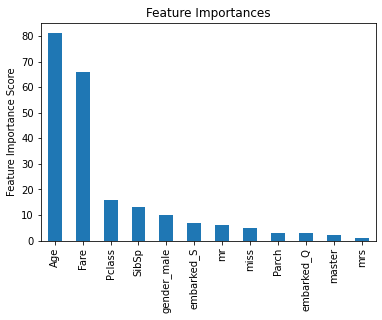

In [140]:
# model karsilastirmasindaki en basarili model
xgb_cl = XGBClassifier(max_depth=6, reg_alpha=1, reg_lambda=0.1, gamma=1)
# modelfit ile modeli xgboost.cv metoduna soktuk
modelfit(xgb_cl, X_train, X_test, y_train, y_test)

- Iki farkli model baslangici secilerek testlere devam edielcek learning_rate : 0.1 ve 0.05 durumu icin ayri ayri testler uygulanacak.

## ***Model baslangici learning_rate: 0.1***

---
### ***1. learning_rate & n_estimators***

- ```learning_rate``` baslangicta farkli problemler icin 0.05 ile 0.3 arasinda bir deger belirlenebilir.
- ```learning_rate``` parametresi kucuk bir deger (0.1) belirlenir ve sonrasinda bu deger icin optimum iterasyon sayisi (agac sayisi ya da ```num_boost_round``` ya da scikit-learn icin ```n_estimators``` parametresi) ```xgboost.cv``` ile elde edilir.
- Default degerler: ```learning_rate:0.3, n_estimators:100```
- Diger parametreler baslangicta tahmini olarak verilmistir, daha sonraki adimlarda ayarlanacaktir.


Model Report
Accuracy (Train) : 0.910112
AUC Score (Train): 0.9662694936043454
Accuracy (Test)  : 0.849162
AUC Score (Test) : 0.9081686429512518
Best iteration   : 61
CV test mean(auc) : 0.872353


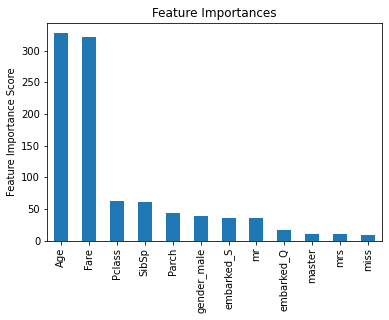

In [175]:
# ilk model parametreleri
xgb11 = XGBClassifier(
    learning_rate=0.1,      # ne kadar kucukse model o kadar iyi genelleme yapar (def:0.3)
    n_estimators=1000,      # toplam kac boost round olacak ve kac agac olusacak (def:100)
    max_depth=5,            # her bir agacin max derinligi (def:6)
    min_child_weight=1,     # dengesiz siniflarda kullanilir(def:1)
    gamma=0,                # min hata azaltmayi belirler (agac bunun altinda split edemez)(def:0)
    subsample=0.8,            # agac olusturuken alinacak orneklem orani (def:1)
    colsample_bytree=0.8,     # agac olusturuken alinacak sutun(feature) orani (def:1)
    scale_pos_weight=1,     # dengesiz siniflarda kullanilmali, (def:1)
    objective= 'binary:logistic') # ikili siniflandirmada hedef

modelfit(xgb11, X_train, X_test, y_train, y_test)

### ***2. max_depth & min_child_weight***

- Modele en cok etki eden ```max_depth, min_child_weight``` oldugundan ilk olarak bu parametrelerle basladik. Deneme araliklari baslangicta yuksek tutulup (coarse-grained) sonrasinda araliklar kucultulecektir(fine-grained).
- Deafult degerler: ```max_depth:6, min_child_weight:1```

In [176]:
%%time

param_test11 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch11 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=61, 
                                                  max_depth=3,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test11, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
gsearch11.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch1.cv_results_))
print("Best params: \n{}\n".format(gsearch11.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch11.best_score_))
print("Test-set score: \n{}\n".format(gsearch11.score(X_test, y_test)))

Best params: 
{'max_depth': 9, 'min_child_weight': 3}

Best cross-validation score: 
0.8795771455410953

Test-set score: 
0.917786561264822

CPU times: user 279 ms, sys: 7.77 ms, total: 286 ms
Wall time: 709 ms


- Araligi 2 den 1 e dusurerek tekrar test edelim ve kacirdigimiz parametreleri de gorelim.

In [177]:
%%time

param_test12 = {
    'max_depth':[8,9,10],
    'min_child_weight':[2,3,4]
}
gsearch12 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=61, 
                                                  max_depth=9,
                                                  min_child_weight=3, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test12, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

gsearch12.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch2.cv_results_))
print("Best params: \n{}\n".format(gsearch12.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch12.best_score_))
print("Test-set score: \n{}\n".format(gsearch12.score(X_test, y_test)))

Best params: 
{'max_depth': 8, 'min_child_weight': 2}

Best cross-validation score: 
0.8802129444919414

Test-set score: 
0.9115942028985508

CPU times: user 257 ms, sys: 3.9 ms, total: 260 ms
Wall time: 630 ms


- ***???*** Bazi durumlarda aradaki parametereler grid search tarafindan secildi ancak bir onceki grid search e gore kotu sonuc verdi.
- Tespit edilen parametre eger kenardaysa(basta-sonda) ona gore devam eden parametrelerle tekrar grid search yapilmali. Sonraki ya da oncekileri kacirmamaliyiz.

In [117]:
# optional, duruma gore
# min_child_weight eger 1 ciksaydi bu sekilde testi devam ettirebilirdik
param_test2b = {
    'min_child_weight':[0.4,0.6,0.8,1]
}

### ***3. gamma***
- gamma ile dalin split etmesi icin minimum loss reduction yani min hata azaltma belirenir. Ne kadar yuksekse dallanma o kadar zor olur ve model konservatif olur.
- ```gamma``` icin 0,0.1,0.2,0.3,0.4 degerlerini test edecegiz.
- Deafult deger ```gamma:0```

In [178]:
%%time

param_test13 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch13 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=61, 
                                                  max_depth=8,
                                                  min_child_weight=2, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test13, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

gsearch13.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch3.cv_results_))
print("Best params: \n{}\n".format(gsearch13.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch13.best_score_))
print("Test-set score: \n{}\n".format(gsearch13.score(X_test, y_test)))

Best params: 
{'gamma': 0.2}

Best cross-validation score: 
0.8807860739051963

Test-set score: 
0.9197628458498023

CPU times: user 219 ms, sys: 3.82 ms, total: 223 ms
Wall time: 427 ms


### ***Recalibration***

- Diger parametrelere devam etmeden once burada agac sayisini (n_estimators) tekrar kalibre etmek uygun olmaktadir.


Model Report
Accuracy (Train) : 0.912921
AUC Score (Train): 0.9686725575108264
Accuracy (Test)  : 0.854749
AUC Score (Test) : 0.9197628458498024
Best iteration   : 62
CV test mean(auc) : 0.873731


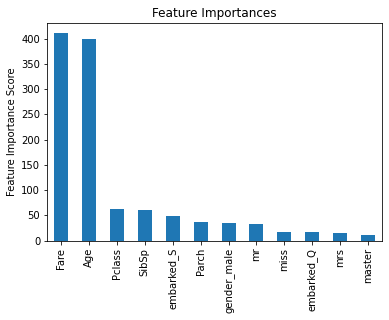

In [179]:
xgb12 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=8,
    min_child_weight=2,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=1)
modelfit(xgb12, X_train, X_test, y_train, y_test)

- En iyi iterasyon sayisi degistiyse guncellenir degismediyse ayni sekilde devam edilir.

- Burada skorda da kucuk bir gelisme gorduk, ```max_depth, min_child_weight, gamma``` parametrelerinde mevcut degerleri kullanabiliriz.

### ***4. subsample & colsample_bytree***

- Burada da testi 2 adimda gerceklestirecegiz. 0.6,0.7,0.8,0.9 baslangic test degerlerimiz.
- Default degerler: ```subsample:1, colsample_bytree:1```

In [180]:
%%time

param_test14 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch14 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=62, 
                                                  max_depth=8,
                                                  min_child_weight=2, 
                                                  gamma=0.2, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test14, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch14.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch4.cv_results_))
print("Best params: \n{}\n".format(gsearch14.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch14.best_score_))
print("Test-set score: \n{}\n".format(gsearch14.score(X_test, y_test)))

Best params: 
{'colsample_bytree': 0.6, 'subsample': 0.6}

Best cross-validation score: 
0.883639846743295

Test-set score: 
0.9192358366271409

CPU times: user 318 ms, sys: 3.99 ms, total: 322 ms
Wall time: 1.03 s


- 0.05 araliginda teste devam ederiz. Buldugumuz degerin 0.05 alti ve 0.05 ustunde de arama yapariz.

In [121]:
[i/100.0 for i in range(65,80,5)]

[0.65, 0.7, 0.75]

In [181]:
%%time

param_test15 = {
    'subsample':[i/100.0 for i in range(55,75,5)],
    'colsample_bytree':[i/100.0 for i in range(55,75,5)]
}
gsearch15 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=62, 
                                                  max_depth=8,
                                                  min_child_weight=2, 
                                                  gamma=0.2, 
                                                  subsample=0.6, 
                                                  colsample_bytree=0.6,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test15, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch15.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch5.cv_results_))
print("Best params: \n{}\n".format(gsearch15.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch15.best_score_))
print("Test-set score: \n{}\n".format(gsearch15.score(X_test, y_test)))

Best params: 
{'colsample_bytree': 0.55, 'subsample': 0.55}

Best cross-validation score: 
0.8873318741226264

Test-set score: 
0.9129117259552043

CPU times: user 293 ms, sys: 4.08 ms, total: 297 ms
Wall time: 950 ms


- Sonuca gore gelisme varsa parametre guncellenir yoksa ilk adimdaki secilir.

### ***5. alpha & lambda***
- Overfittingi azaltmak icin regularizasyon parametrelerini de test etmeliyiz. 
- Burada yalnizca alpha (L2 - Ridge) parametresi tespit edilip birakilabilir ya da lambda (L1- Lasso) icin de alpha icin tekrar edilen arama adimlari uygulanabilir.
- Default degerler:```reg_alpha:0, reg_lambda:1```

In [184]:
param_test16 = {
    'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}

gsearch16 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=62, 
                                                  max_depth=8,
                                                  min_child_weight=2, 
                                                  gamma=0.2, 
                                                  subsample=0.55, 
                                                  colsample_bytree=0.55,
                                                  objective= 'binary:logistic',  
                                                  scale_pos_weight=1), 
                        param_grid = param_test16, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch16.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch6.cv_results_))
print("Best params: \n{}\n".format(gsearch16.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch16.best_score_))
print("Test-set score: \n{}\n".format(gsearch16.score(X_test, y_test)))

Best params: 
{'reg_alpha': 0}

Best cross-validation score: 
0.8873318741226264

Test-set score: 
0.9129117259552043



- Alpha default deger 0 ciktiysa regualarizasyona gerek yoktur.
- Default degerden farkli ise birinci adimda genis adimlarla aram yapildigindan buradaki sonuca gore ikinci adimda daha sik adimlarla fine-grained arama yapilir.

In [128]:
np.arange(0.0, 0.000012, 0.000002)

array([0.e+00, 2.e-06, 4.e-06, 6.e-06, 8.e-06, 1.e-05])

In [185]:
# optional
param_test17 = {
    'reg_alpha': np.arange(0.0, 0.000012, 0.000002)
}

gsearch17 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=62, 
                                                  max_depth=8,
                                                  min_child_weight=2, 
                                                  gamma=0.2, 
                                                  subsample=0.55, 
                                                  colsample_bytree=0.55,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test17, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch17.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")

#display(pd.DataFrame(gsearch7.cv_results_))
print("Best params: \n{}\n".format(gsearch17.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch17.best_score_))
print("Test-set score: \n{}\n".format(gsearch17.score(X_test, y_test)))

Best params: 
{'reg_alpha': 0.0}

Best cross-validation score: 
0.8873318741226264

Test-set score: 
0.9129117259552043



- ```reg_lambda``` icin de ayni adimlar tekrar edilebilir.
- Default deger: ```reg_lambda:1```

In [186]:
param_test18 = {
    'reg_lambda':[0, 1e-5, 1e-2, 0.1, 1, 100]
}

gsearch18 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, 
                                                  n_estimators=62, 
                                                  max_depth=8,
                                                  min_child_weight=2, 
                                                  gamma=0.2, 
                                                  subsample=0.55, 
                                                  colsample_bytree=0.55,
                                                  reg_alpha=0,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test18, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch18.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch8.cv_results_))
print("Best params: \n{}\n".format(gsearch18.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch18.best_score_))
print("Test-set score: \n{}\n".format(gsearch18.score(X_test, y_test)))

Best params: 
{'reg_lambda': 1}

Best cross-validation score: 
0.8873318741226264

Test-set score: 
0.9129117259552043



- CV skorunda gelisme varsa parametre secilir yoksa secilmez. 
- Sonucta secilen parametrelerle tekrar model xgboost.cv ile test edilirek yeni eklenen parametrelerin etkisi gozlenir.
- ***???*** Ancak burada secilen parametrelerle model performansi dustu.


Model Report
Accuracy (Train) : 0.912921
AUC Score (Train): 0.9748596126728245
Accuracy (Test)  : 0.843575
AUC Score (Test) : 0.8984189723320158
Best iteration   : 56
CV test mean(auc) : 0.866204


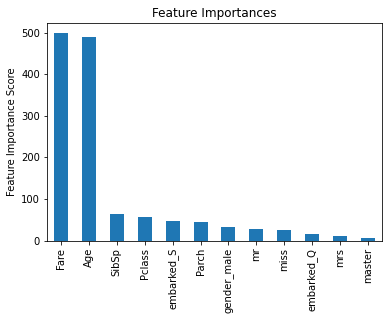

In [188]:
xgb13 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=8,
    min_child_weight=2,
    gamma=0.2,
    subsample=0.55,
    colsample_bytree=0.55,
    reg_alpha=0,
    reg_lambda=1,
    objective='binary:logistic',
    scale_pos_weight=1)
modelfit(xgb13, X_train, X_test, y_train, y_test)

## ***Model baslangici learning_rate: 0.05***

---
### ***1. learning_rate & n_estimators***

- ```learning_rate``` baslangicta farkli problemler icin 0.05 ile 0.3 arasinda bir deger belirlenebilir.
- ```learning_rate``` parametresi kucuk bir deger (0.1) belirlenir ve sonrasinda bu deger icin optimum iterasyon sayisi (agac sayisi ya da ```num_boost_round``` ya da scikit-learn icin ```n_estimators``` parametresi) ```xgboost.cv``` ile elde edilir.
- Default degerler: ```learning_rate:0.3, n_estimators:100```
- Diger parametreler baslangicta tahmini olarak verilmistir, daha sonraki adimlarda ayarlanacaktir.


Model Report
Accuracy (Train) : 0.910112
AUC Score (Train): 0.9701744724523768
Accuracy (Test)  : 0.849162
AUC Score (Test) : 0.9035573122529644
Best iteration   : 131
CV test mean(auc) : 0.860760


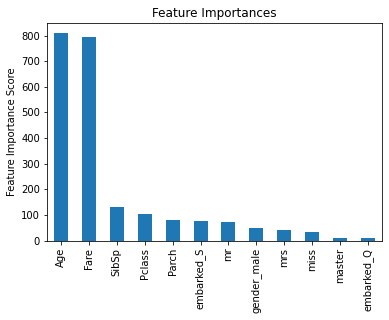

In [112]:
# ilk model parametreleri
xgb21 = XGBClassifier(
    learning_rate=0.05,     # ne kadar kucukse model o kadar iyi genelleme yapar (def:0.3)
    n_estimators=1000,      # toplam kac boost round olacak ve kac agac olusacak (def:100)
    max_depth=5,            # her bir agacin max derinligi (def:6)
    min_child_weight=1,     # dengesiz siniflarda kullanilir(def:1)
    gamma=0,                # min hata azaltmayi belirler (agac bunun altinda split edemez)(def:0)
    subsample=1,          # agac olusturuken alinacak orneklem orani (def:1)
    colsample_bytree=1,   # agac olusturuken alinacak sutun(feature) orani (def:1)
    scale_pos_weight=1,     # dengesiz siniflarda kullanilmali, (def:1)
    objective= 'binary:logistic') # ikili siniflandirmada hedef

modelfit(xgb21, X_train, X_test, y_train, y_test)

### ***2. max_depth & min_child_weight***

- Modele en cok etki eden ```max_depth, min_child_weight``` oldugundan ilk olarak bu parametrelerle basladik. Deneme araliklari baslangicta yuksek tutulup (coarse-grained) sonrasinda araliklar kucultulecektir(fine-grained).
- Deafult degerler: ```max_depth:6, min_child_weight:1```

In [189]:
%%time

param_test21 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch21 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05, 
                                                  n_estimators=131, 
                                                  max_depth=3,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=1, 
                                                  colsample_bytree=1, 
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test21, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)
gsearch21.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch1.cv_results_))
print("Best params: \n{}\n".format(gsearch21.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch21.best_score_))
print("Test-set score: \n{}\n".format(gsearch21.score(X_test, y_test)))

Best params: 
{'max_depth': 7, 'min_child_weight': 5}

Best cross-validation score: 
0.8768546225050926

Test-set score: 
0.9094861660079051

CPU times: user 435 ms, sys: 7.98 ms, total: 443 ms
Wall time: 1.37 s


- Araligi 2 den 1 e dusurerek tekrar test edelim ve kacirdigimiz parametreleri de gorelim.

In [190]:
%%time

param_test22 = {
    'max_depth':[6,7,8],
    'min_child_weight':[4,5,6]
}
gsearch22 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05, 
                                                  n_estimators=131, 
                                                  max_depth=7,
                                                  min_child_weight=5, 
                                                  gamma=0, 
                                                  subsample=1, 
                                                  colsample_bytree=1,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test22, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

gsearch22.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch2.cv_results_))
print("Best params: \n{}\n".format(gsearch22.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch22.best_score_))
print("Test-set score: \n{}\n".format(gsearch22.score(X_test, y_test)))

Best params: 
{'max_depth': 7, 'min_child_weight': 5}

Best cross-validation score: 
0.8768546225050926

Test-set score: 
0.9094861660079051

CPU times: user 379 ms, sys: 7.86 ms, total: 386 ms
Wall time: 1.08 s


- ***???*** Bazi durumlarda aradaki parametereler grid search tarafindan secildi ancak bir onceki grid search e gore kotu sonuc verdi.
- Tespit edilen parametre eger kenardaysa(basta-sonda) ona gore devam eden parametrelerle tekrar grid search yapilmali. Sonraki ya da oncekileri kacirmamaliyiz.

In [117]:
# optional, duruma gore
# min_child_weight eger 1 ciksaydi bu sekilde testi devam ettirebilirdik
param_test2b = {
    'min_child_weight':[0.4,0.6,0.8,1]
}

### ***3. gamma***
- gamma ile dalin split etmesi icin minimum loss reduction yani min hata azaltma belirenir. Ne kadar yuksekse dallanma o kadar zor olur ve model konservatif olur.
- ```gamma``` icin 0,0.1,0.2,0.3,0.4 degerlerini test edecegiz.
- Deafult deger ```gamma:0```

In [191]:
%%time

param_test23 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch23 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05, 
                                                  n_estimators=131, 
                                                  max_depth=7,
                                                  min_child_weight=5, 
                                                  gamma=0, 
                                                  subsample=1, 
                                                  colsample_bytree=1,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test23, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5)

gsearch23.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch3.cv_results_))
print("Best params: \n{}\n".format(gsearch23.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch23.best_score_))
print("Test-set score: \n{}\n".format(gsearch23.score(X_test, y_test)))

Best params: 
{'gamma': 0.0}

Best cross-validation score: 
0.8768546225050926

Test-set score: 
0.9094861660079051

CPU times: user 327 ms, sys: 4.05 ms, total: 331 ms
Wall time: 672 ms


### ***Recalibration***

- Diger parametrelere devam etmeden once burada agac sayisini (n_estimators) tekrar kalibre etmek uygun olmaktadir.


Model Report
Accuracy (Train) : 0.894663
AUC Score (Train): 0.947553964638247
Accuracy (Test)  : 0.854749
AUC Score (Test) : 0.9108036890645587
Best iteration   : 140
CV test mean(auc) : 0.868082


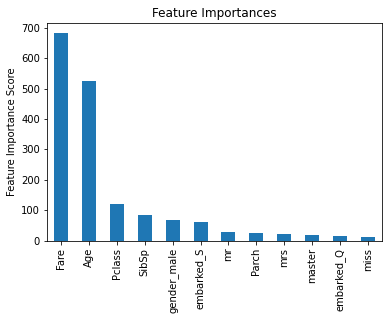

In [192]:
xgb22 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=7,
    min_child_weight=5,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    objective= 'binary:logistic',
    scale_pos_weight=1)
modelfit(xgb22, X_train, X_test, y_train, y_test)

- En iyi iterasyon sayisi degisti.

- Burada skorda da bir gelisme gorduk, ```max_depth, min_child_weight, gamma``` parametrelerinde mevcut degerleri kullanabiliriz.

### ***4. subsample & colsample_bytree***

- Burada da testi 2 adimda gerceklestirecegiz. 0.6,0.7,0.8,0.9 baslangic test degerlerimiz.
- Default degerler: ```subsample:1, colsample_bytree:1```

In [195]:
%%time

param_test24 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch24 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05, 
                                                  n_estimators=140, 
                                                  max_depth=7,
                                                  min_child_weight=5, 
                                                  gamma=0, 
                                                  subsample=1, 
                                                  colsample_bytree=1,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test24, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch24.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch4.cv_results_))
print("Best params: \n{}\n".format(gsearch24.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch24.best_score_))
print("Test-set score: \n{}\n".format(gsearch24.score(X_test, y_test)))

Best params: 
{'colsample_bytree': 0.7, 'subsample': 0.9}

Best cross-validation score: 
0.8780353165933104

Test-set score: 
0.904874835309618

CPU times: user 428 ms, sys: 12 ms, total: 440 ms
Wall time: 1.7 s


- 0.05 araliginda teste devam ederiz. Buldugumuz degerin 0.05 alti ve 0.05 ustunde de arama yapariz.

In [121]:
[i/100.0 for i in range(65,80,5)]

[0.65, 0.7, 0.75]

In [196]:
%%time

param_test25 = {
    'subsample':[i/100.0 for i in range(85,100,5)],
    'colsample_bytree':[i/100.0 for i in range(65,75,5)]
}
gsearch25 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05, 
                                                  n_estimators=140, 
                                                  max_depth=7,
                                                  min_child_weight=5, 
                                                  gamma=0, 
                                                  subsample=0.9, 
                                                  colsample_bytree=0.7,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test25, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch25.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch5.cv_results_))
print("Best params: \n{}\n".format(gsearch25.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch25.best_score_))
print("Test-set score: \n{}\n".format(gsearch25.score(X_test, y_test)))

Best params: 
{'colsample_bytree': 0.7, 'subsample': 0.9}

Best cross-validation score: 
0.8780353165933104

Test-set score: 
0.904874835309618

CPU times: user 317 ms, sys: 7.98 ms, total: 325 ms
Wall time: 692 ms


- Sonuca gore gelisme varsa parametre guncellenir yoksa ilk adimdaki secilir.

### ***5. alpha & lambda***
- Overfittingi azaltmak icin regularizasyon parametrelerini de test etmeliyiz. 
- Burada yalnizca alpha (L2 - Ridge) parametresi tespit edilip birakilabilir ya da lambda (L1- Lasso) icin de alpha icin tekrar edilen arama adimlari uygulanabilir.
- Default degerler:```reg_alpha:0, reg_lambda:1```

In [197]:
param_test26 = {
    'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}

gsearch26 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05, 
                                                  n_estimators=140, 
                                                  max_depth=7,
                                                  min_child_weight=5, 
                                                  gamma=0, 
                                                  subsample=0.9, 
                                                  colsample_bytree=0.7,
                                                  objective= 'binary:logistic',  
                                                  scale_pos_weight=1), 
                        param_grid = param_test26, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch26.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch6.cv_results_))
print("Best params: \n{}\n".format(gsearch26.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch26.best_score_))
print("Test-set score: \n{}\n".format(gsearch26.score(X_test, y_test)))

Best params: 
{'reg_alpha': 0}

Best cross-validation score: 
0.8780353165933104

Test-set score: 
0.904874835309618



- Birinci adimda genis adimlarla aram yapildi buradaki sonuca gore ikinci adimda daha sik adimlarla fine-grained arama yapilir.
- Alpha default deger 0 ciktiysa regualarizasyona gerek yoktur.

In [128]:
np.arange(0.0, 0.000012, 0.000002)

array([0.e+00, 2.e-06, 4.e-06, 6.e-06, 8.e-06, 1.e-05])

In [198]:
# optional
param_test27 = {
    'reg_alpha': np.arange(0.0, 0.000012, 0.000002)
}

gsearch27 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.05, 
                                                  n_estimators=140, 
                                                  max_depth=7,
                                                  min_child_weight=5, 
                                                  gamma=0, 
                                                  subsample=0.9, 
                                                  colsample_bytree=0.7,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test27, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch27.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")

#display(pd.DataFrame(gsearch7.cv_results_))
print("Best params: \n{}\n".format(gsearch27.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch27.best_score_))
print("Test-set score: \n{}\n".format(gsearch27.score(X_test, y_test)))

Best params: 
{'reg_alpha': 0.0}

Best cross-validation score: 
0.8780353165933104

Test-set score: 
0.904874835309618



- ```reg_lambda``` icin de ayni adimlar tekrar edilebilir.
- Default deger: ```reg_lambda:1```

In [199]:
param_test28 = {
    'reg_lambda':[0, 1e-5, 1e-2, 0.1, 1, 100]
}

gsearch28 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, 
                                                  n_estimators=140, 
                                                  max_depth=7,
                                                  min_child_weight=5, 
                                                  gamma=0, 
                                                  subsample=0.9, 
                                                  colsample_bytree=0.7,
                                                  reg_alpha=0,
                                                  objective= 'binary:logistic', 
                                                  scale_pos_weight=1), 
                        param_grid = param_test28, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch28.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
#display(pd.DataFrame(gsearch8.cv_results_))
print("Best params: \n{}\n".format(gsearch28.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch28.best_score_))
print("Test-set score: \n{}\n".format(gsearch28.score(X_test, y_test)))

Best params: 
{'reg_lambda': 0}

Best cross-validation score: 
0.8787109337893038

Test-set score: 
0.907905138339921



- CV skorunda gelisme varsa parametre secilir yoksa secilmez. 
- Sonucta secilen parametrelerle tekrar model xgboost.cv ile test edilirek yeni eklenen parametrelerin etkisi gozlenir.


Model Report
Accuracy (Train) : 0.901685
AUC Score (Train): 0.9609210076180463
Accuracy (Test)  : 0.854749
AUC Score (Test) : 0.9085638998682477
Best iteration   : 242
CV test mean(auc) : 0.874429


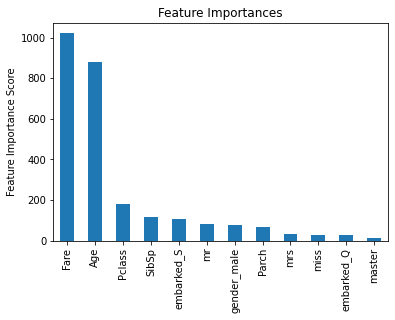

In [200]:
xgb23 = XGBClassifier(
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=7,
    min_child_weight=5,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.7,
    reg_alpha=0,
    reg_lambda=0,
    objective='binary:logistic',
    scale_pos_weight=1)
modelfit(xgb23, X_train, X_test, y_train, y_test)

### ***6. Reducing Learning Rate***
- Son olarak secilen parametrelerle learning_rate azaltilarak agac sayisi artirilir ve modelin genellestirme ozelligi maksimum duzeye cikarilmaya calisilir.
- Ancak burada learning_rate azaltildiginda model performansi dustugunden degisiklik yapilmadi.


Model Report
Accuracy (Train) : 0.896067
AUC Score (Train): 0.9550301634584095
Accuracy (Test)  : 0.849162
AUC Score (Test) : 0.9102766798418973
Best iteration   : 303
CV test mean(auc) : 0.874966


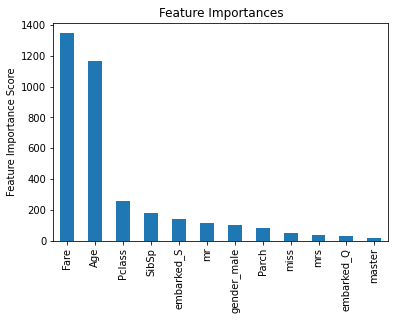

In [202]:
xgb24 = XGBClassifier(
    learning_rate=0.03,
    n_estimators=1000,
    max_depth=7,
    min_child_weight=5,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.7,
    reg_alpha=0,
    reg_lambda=0,
    objective='binary:logistic',
    scale_pos_weight=1)
modelfit(xgb24, X_train, X_test, y_train, y_test)

- Testlerde yuksek performans veren bir model.


Model Report
Accuracy (Train) : 0.904494
AUC Score (Train): 0.964045825093661
Accuracy (Test)  : 0.871508
AUC Score (Test) : 0.9055335968379447
Best iteration   : 51
CV test mean(auc) : 0.866169


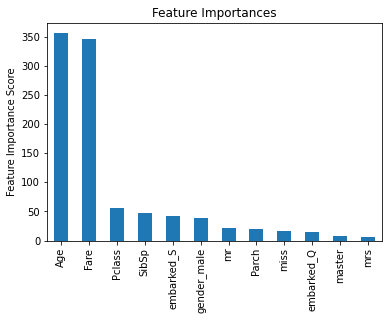

In [201]:
xgb_test = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=9,
    min_child_weight=3,
    gamma=0.3,
    #subsample=0.95,
    #colsample_bytree=0.6,
    #reg_alpha=0.27,
    #reg_lambda=0,
    objective='binary:logistic',
    scale_pos_weight=1)
modelfit(xgb_test, X_train, X_test, y_train, y_test)

### ***Grid Search Testi***

In [206]:
param_test_comp = [{'learning_rate': [0.1], 'n_estimators': [51],
                    'max_depth': [9],  'min_child_weight': [3], 'gamma': [0.3],
                    'subsample': [1], 'colsample_bytree': [1], 
                    'reg_alpha': [0], 'reg_lambda': [1]},
                   {'learning_rate': [0.05], 'n_estimators': [242], 
                    'max_depth': [7],  'min_child_weight': [5], 'gamma': [0],
                    'subsample': [0.9], 'colsample_bytree': [0.7], 
                    'reg_alpha': [0], 'reg_lambda': [0]}]

gsearch_comp = GridSearchCV(estimator = XGBClassifier(objective= 'binary:logistic'), 
                        param_grid = param_test_comp, 
                        scoring='roc_auc',
                        return_train_score=True,
                        n_jobs=4, 
                        cv=5)

gsearch_comp.fit(X_train,y_train)

# sonuclar
#print("Grid scores: \n")
display(pd.DataFrame(gsearch_comp.cv_results_))
print("Best params: \n{}\n".format(gsearch_comp.best_params_))
print("Best cross-validation score: \n{}\n".format(gsearch_comp.best_score_))
print("Test-set score: \n{}\n".format(gsearch_comp.score(X_test, y_test)))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.058,0.017,0.004,0.001,1,0.300,0.100,9,3,51,0,1,1,"{'colsample_bytree': 1, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': ...",0.884,0.904,0.843,0.836,0.909,0.875,0.031,2,0.962,0.962,0.964,0.963,0.960,0.962,0.001
1,0.115,0.020,0.004,0.001,0.700,0,0.050,7,5,242,0,0,0.900,"{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight':...",0.870,0.912,0.858,0.853,0.912,0.881,0.026,1,0.959,0.958,0.961,0.963,0.955,0.959,0.003


Best params: 
{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 242, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.9}

Best cross-validation score: 
0.8808749986806413

Test-set score: 
0.9085638998682477



#### ***Sonuc***

- ***???*** Bazi durmlar icin skorda gelisme goremedik hatta hafif bir azalma gorduk. Grid search skorlarindaki performans artisina ragmen xgboost.cv metodundaki skorlarda azalma ya da sabit durum tespit edildi.

- ***???*** xgboost.cv metodunda iyi performans gosteren model grid search te daha dusuk performanstaydi. Iki metodun farkli ozellikleri buna neden olmus olabilir.

- En iyi tahmin modeli:

In [208]:
# en iyi tahmin modeli
gsearch_comp.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=242, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=0, scale_pos_weight=1, subsample=0.9, tree_method=None,
              validate_parameters=False, verbosity=None)